# Jet Compression using an Autoencoder

In [1]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

pT       eta       phi            E
1367643  300.752869  0.118391 -1.460827   303.719818
1739612   79.819145  4.535507 -1.185196  3722.832764
546066   220.472305  1.314261 -0.943992   440.195190
213212    74.533775  0.010658 -0.424795    74.770332
150544   220.668121  2.432910 -2.308348  1266.681030
574837   159.841782  0.731125 -1.150598   207.133514
1171687  306.125305  0.702473  0.437615   385.713013
1608254  189.011673 -1.387443  0.490634   403.126709
1618830  194.996719 -1.022815 -1.560437   306.534515
637947   186.887146 -0.621282 -0.465523   226.002701

## Normalizing and splitting into train and test datasets

In [4]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [17]:
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

In [18]:
class AE(nn.Module):
    def __init__(self, n_features=4, dropout=0.5):
        super(AE, self).__init__()
        if type(dropout) is list:
            p1 = dropout[0]
            p2 = dropout[1]
            p3 = dropout[2]
            p4 = dropout[3]
            p5 = dropout[4]
            p6 = dropout[5]
            p7 = dropout[6]
        else:
            p1 = dropout
            p2 = dropout
            p3 = dropout
            p4 = dropout
            p5 = dropout
            p6 = dropout
            p7 = dropout
        self.en1 = nn.Linear(n_features, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.en2 = nn.Linear(200, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.en3 = nn.Linear(100, 50)
        self.bn3 = nn.BatchNorm1d(50)
        self.en4 = nn.Linear(50, 3)
        self.bn5 = nn.BatchNorm1d(3)
        self.de1 = nn.Linear(3, 50)
        self.bn6 = nn.BatchNorm1d(50)
        self.de2 = nn.Linear(50, 100)
        self.bn7 = nn.BatchNorm1d(100)
        self.de3 = nn.Linear(100, 200)
        self.bn8 = nn.BatchNorm1d(200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        self.drop3 = nn.Dropout(p3)
        self.drop4 = nn.Dropout(p4)
        self.drop5 = nn.Dropout(p5)
        self.drop6 = nn.Dropout(p6)
        self.drop7 = nn.Dropout(p7)
        

    def encode(self, x):
        h1 = self.drop1(self.bn1(self.tanh(self.en1(x))))
        h2 = self.drop2(self.bn2(self.tanh(self.en2(h1))))
        h3 = self.drop3(self.bn3(self.tanh(self.en3(h2))))
        z = self.en4(h3)
        return z

    def decode(self, x):
        h5 = self.drop5(self.bn6(self.tanh(self.de1(self.drop4(self.bn5(self.tanh(x)))))))
        h6 = self.drop6(self.bn7(self.tanh(self.de2(h5))))
        h7 = self.drop7(self.bn8(self.tanh(self.de3(h6))))
        return self.de4(h7)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        pass

In [19]:
n_features = len(train.loc[0])
model = AE(dropout=0.001)

In [ ]:
# Training
epochs_list = [7, 5, 3, 2, 2]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model.parameters(), lr=lrs[ii], weight_decay=0.01)
    fit(epochs, model, loss_func, opt, train_dl, valid_dl, device)

Setting learning rate to 1.0e-03
Epoch 0: Validation loss = 0.026436789239913626 Time: 0:03:18.460879
Epoch 1: Validation loss = 0.009576280565291003 Time: 0:17:39.694324
Epoch 2: Validation loss = 0.018151680810442307 Time: 0:44:11.608858


In [29]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
#save_path = './models/AE_3D_v2_bs256_loss28eneg7.pt'
#torch.save(model.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [30]:
model.eval()

AE_3D(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [31]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6850, -0.7091,  1.6959,  0.2734], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1768, -0.1646, -0.0310, -0.5935], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3741,  0.6505,  1.3036, -0.5509], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3717, -0.0072,  1.0897, -0.7273], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7823, -0.3969,  1.1575, -0.7659], grad_fn=<AddBackward0>)
 


In [32]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [430.6787     -1.152757    3.0978954 752.1524   ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.4779137e+02 -2.8423893e-01 -4.7612809e-02  2.5917880e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [180.98077     1.0158684   2.3832366 283.36844  ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [ 1.8126926e+02 -3.3117883e-02  1.9937130e+00  1.8305246e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [131.48422    -0.6547884   2.117223  161.1287   ]
 


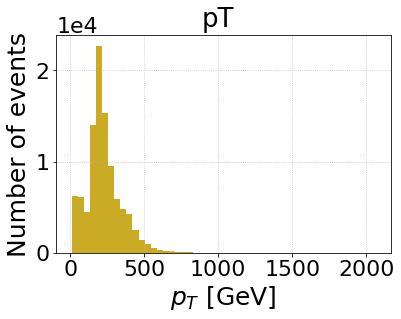

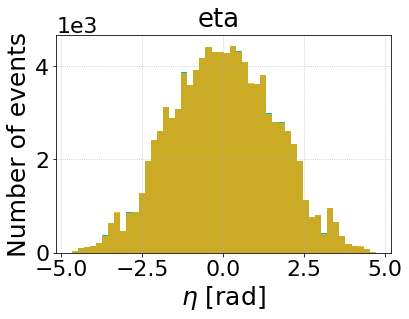

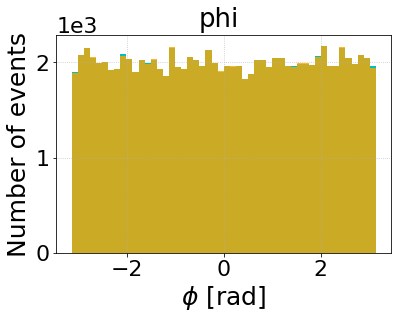

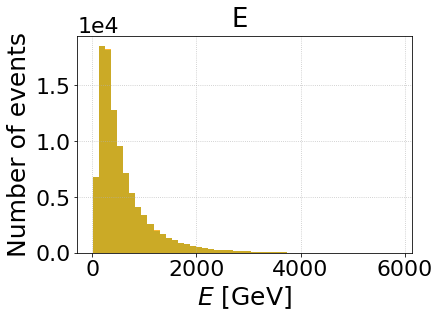

In [33]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()

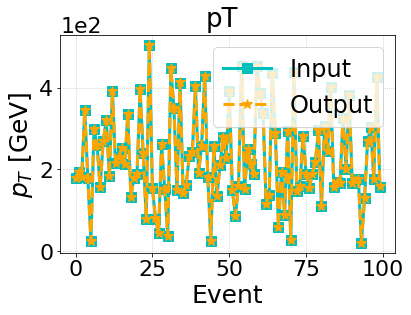

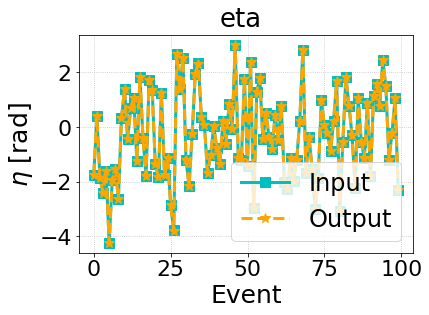

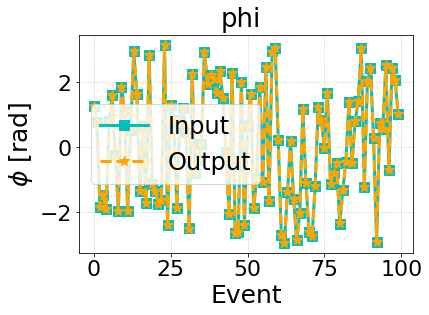

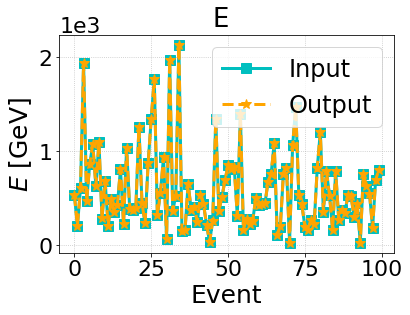

In [34]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [35]:
# Plot input on top of output
idxs = (0, int(1.9e6))  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

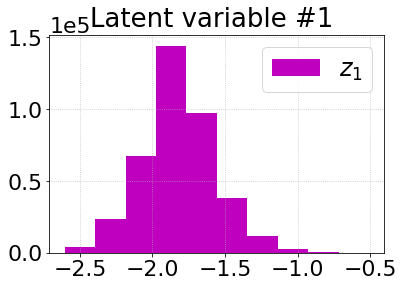

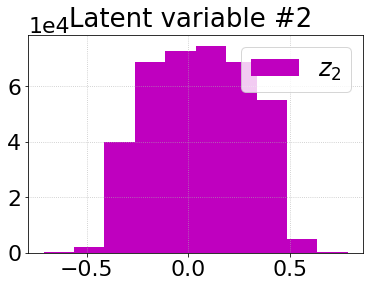

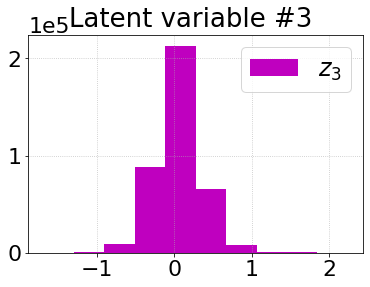

In [36]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0.5, 0, '$z_3$')

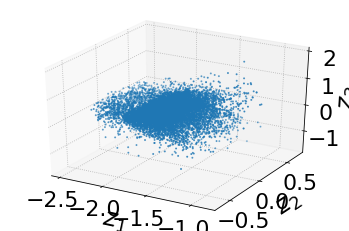

In [37]:
from mpl_toolkits.mplot3d import Axes3D

idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
latent = model.encode(data).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latent[:, 0], latent[:, 1], latent[:, 2], s=1)
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.set_zlabel(r'$z_3$')

Text(0, 0.5, '$z_3$')

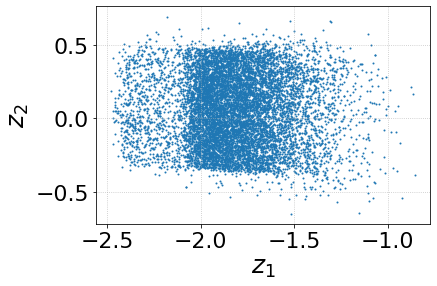

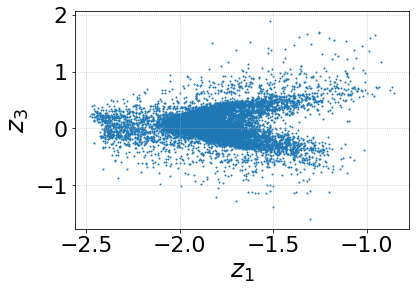

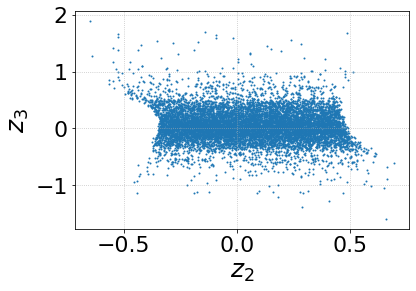

In [38]:
mksz = 1

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')

plt.figure()
plt.scatter(latent[:, 0], latent[:, 2], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_3$')

plt.figure()
plt.scatter(latent[:, 1], latent[:, 2], s=mksz)
plt.xlabel(r'$z_2$')
plt.ylabel(r'$z_3$')